# scilpy

In [1]:
# Helper function to display images in this notebook
def display_image(path, invert=True, big=False):
    try:
        import google.colab
        import cv2
        from google.colab.patches import cv2_imshow
        t1_img = cv2.imread(path,-1)
        cv2_imshow(t1_img)
    except:
        origin = 'lower' if invert else 'upper'
        from matplotlib import pyplot as plt
        if big:
            plt.rcParams["figure.figsize"] = (20,20)
        else:
            plt.rcParams["figure.figsize"] = (5,5)            
        image = plt.imread(path)
        plt.imshow(image,origin=origin)

First, let's install scilpy ! **scilpy requires Python 3.10. It is highly recommended to install it in a fresh virtual environment.**

About virtual environments: https://virtualenv.pypa.io/en/latest/

In [2]:
!pip install pyopencl # For GPU tracking, disregard if you do not have one
!pip install git+https://github.com/scilus/scilpy@master --force


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/scilus/scilpy (to revision master) to /tmp/pip-req-build-n24epf93
  Running command git clone --filter=blob:none --quiet https://github.com/scilus/scilpy /tmp/pip-req-build-n24epf93
  Resolved https://github.com/scilus/scilpy to commit 82fdf5fdc3359e723cd3c2de4ad8cebfc8d9a2ff
  Preparing metadata (setup.py) ... done
  Using cached bids_validator-1.11.0-py2.py3-none-any.whl.metadata (38 kB)
  Using cached bctpy-0.5.2-py3-none-any.whl (102 kB)
  Using cached bz2file-0.98-py3-none-any.whl
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached cvxpy-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.8 kB)
  Using cached cycler-0.11.0-py3-none-any.whl.metadata (785 bytes)
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 k

Then, let's load some data. scilpy depends on dipy so we can use its functionalities here:

In [3]:
from dipy.data import get_fnames
# Download diffusion
dwi, bval, bvec = get_fnames('stanford_hardi')
# Download T1w
t1 = get_fnames('stanford_t1')
# Download T1w parcellation
aparc = get_fnames('stanford_labels')
# Download partial volume maps
csf, gm, wm = get_fnames('stanford_pve_maps')
# Download labels for the parcellation
!wget https://stacks.stanford.edu/file/druid:yx282xq2090/label_info.txt
label_info='label_info.txt'

--2024-02-26 15:39:34--  https://stacks.stanford.edu/file/druid:yx282xq2090/label_info.txt
Resolving stacks.stanford.edu (stacks.stanford.edu)... 171.67.37.91
Connecting to stacks.stanford.edu (stacks.stanford.edu)|171.67.37.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3136 (3.1K) [text/plain]
Saving to: ‘label_info.txt’

label_info.txt      100%[===================>]   3.06K  --.-KB/s    in 0s      

2024-02-26 15:39:35 (8.63 MB/s) - ‘label_info.txt’ saved [3136/3136]



scilpy is a collection of tools with a CLI interface. We will call scripts using `!scil_...`. Let's look at the many scripts `scilpy` has:

In [4]:
!compgen -c | grep "scil_" | sort

scil_add_tracking_mask_to_pft_maps.py
scil_analyse_lesions_load.py
scil_aodf_metrics.py
scil_apply_bias_field_on_dwi.py
scil_apply_transform_to_bvecs.py
scil_apply_transform_to_hdf5.py
scil_apply_transform_to_image.py
scil_apply_transform_to_surface.py
scil_apply_transform_to_tractogram.py
scil_assign_custom_color_to_tractogram.py
scil_assign_uniform_color_to_tractograms.py
scil_bids_validate.py
scil_bingham_metrics.py
scil_btensor_metrics.py
scil_bundle_compute_centroid.py
scil_bundle_compute_endpoints_map.py
scil_bundle_diameter.py
scil_bundle_filter_by_occurence.py
scil_bundle_generate_priors.py
scil_bundle_label_map.py
scil_bundle_mean_fixel_afd_from_hdf5.py
scil_bundle_mean_fixel_afd.py
scil_bundle_mean_fixel_bingham_metric.py
scil_bundle_mean_std.py
scil_bundle_pairwise_comparison.py
scil_bundle_score_many_bundles_one_tractogram.py
scil_bundle_score_same_bundle_many_segmentations.py
scil_bundle_shape_measures.py
scil_bundle_volume_per_label.py
scil_clean_qbx_clusters.py
scil_comb

**That's a lot.** Fortunately, we can search for scripts given a functionality we want. For example, if searching for a script about connectivity, we can do:

In [5]:
!scil_search_keywords.py connectivity

INFO:root:Scilpy version: 1.7.dev0
INFO:root:============================= scil_compute_pca.py ==============================
INFO:root:Script to compute PCA analysis on diffusion metrics.
INFO:root:========================== End of scil_compute_pca.py ==========================
INFO:root:

INFO:root:=================== scil_connectivity_compare_populations.py ===================
INFO:root:Performs a network-based statistical comparison for populations g1 and g2.
INFO:root:=============== End of scil_connectivity_compare_populations.py ================
INFO:root:

INFO:root:==================== scil_connectivity_compute_matrices.py =====================
INFO:root:This script computes a variety of measures in the form of connectivity
matrices.
INFO:root:================= End of scil_connectivity_compute_matrices.py =================
INFO:root:

INFO:root:========================= scil_connectivity_filter.py ==========================
INFO:root:Script to facilitate filtering of connectiv

Let's visualize our data. We'll first extract the b0 image so we can have a proper look at the diffusion, then we will produce screenshot of our b0 and T1 volumes.

Every script has a descriptive manual which can be called with the argument --help. Let's look at the `help` of `scil_dwi_extract_b0.py`:

In [6]:
!scil_dwi_extract_b0.py --help

INFO:root:Scilpy version: 1.7.dev0
usage: scil_dwi_extract_b0.py [-h] [--b0_thr B0_THR]
                              [--all | --mean | --cluster-mean | --cluster-first]
                              [--block-size INT] [--single-image]
                              [-v [{DEBUG,INFO,WARNING}]]
                              [--force_b0_threshold] [-f]
                              in_dwi in_bval in_bvec out_b0

Extract B0s from DWI, based on the bval and bvec information.

The default behavior is to save the first b0 of the series.

Formerly: scil_extract_b0.py

positional arguments:
  in_dwi                DWI Nifti image.
  in_bval               b-values filename, in FSL format (.bval).
  in_bvec               b-values filename, in FSL format (.bvec).
  out_b0                Output b0 file(s).

options:
  -h, --help            show this help message and exit
  --b0_thr B0_THR       All b-values with values less than or equal to b0_thr are considered as b0s i.e. without diffusion weight

# QCing the data

In this section, we will take a look at our data to ensure that it is not corrupted or overly noisy. We'll use **scil_dwi_extract_b0.py** to extract a b0 image from a diffusion volume, **scil_screenshot_volume.py** to take a screenshot of a volume to visualize one or multiple slices, **scil_header_validate_compatibility.py** to ensure that all our volumes live in the same space and **scil_header_print_info.py** to have additional information on our volume.

Now let's extract the b0:

In [7]:
!scil_dwi_extract_b0.py {dwi} {bval} {bvec} b0.nii.gz -f

INFO:root:Scilpy version: 1.7.dev0


Finally, let's have look at our b0 and T1 images. First we'll create some screenshots of our volumes:

In [8]:
!scil_screenshot_volume.py {t1} t1.png --axis coronal --slice_id 47 -f
!scil_screenshot_volume.py b0.nii.gz b0.png --axis coronal --slice_id 47 -f

INFO:root:Scilpy version: 1.7.dev0
INFO:root:Scilpy version: 1.7.dev0


Then let's display them.

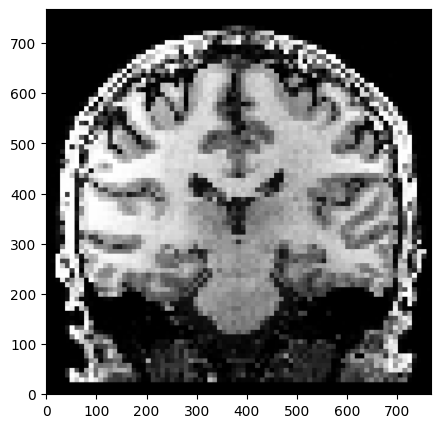

In [9]:
display_image('t1_slice_47.png')

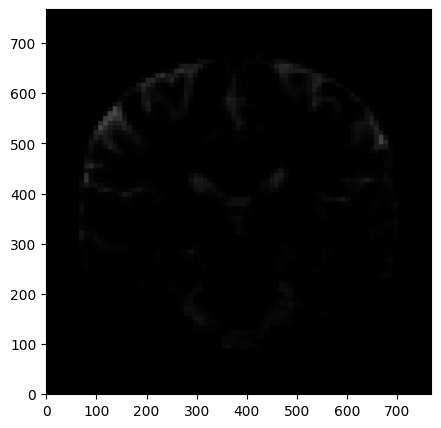

In [10]:
display_image('b0_slice_47.png')

Now, let's make sure the data is correct and lives in the same space. We'll verify this with `scil_header_validate_compatibility.py`.

In [11]:
!scil_header_validate_compatibility.py {dwi} {t1}

INFO:root:Scilpy version: 1.7.dev0
All input files have compatible headers.


Yes ! The script mentions the header, let's have a look at it.

In [12]:
!scil_header_print_info.py {dwi}

INFO:root:Scilpy version: 1.7.dev0
{'aux_file': array(b'', dtype='|S24'),
 'bitpix': array(16, dtype=int16),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'data_type': array(b'', dtype='|S10'),
 'datatype': array(4, dtype=int16),
 'db_name': array(b'', dtype='|S18'),
 'descrip': array(b'', dtype='|S80'),
 'dim': array([  4,  81, 106,  76, 160,   1,   1,   1], dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'extents': array(0, dtype=int32),
 'glmax': array(0, dtype=int32),
 'glmin': array(0, dtype=int32),
 'intent_code': array(0, dtype=int16),
 'intent_name': array(b'', dtype='|S16'),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'magic': array(b'n+1', dtype='|S4'),
 'pixdim': array([1., 2., 2., 2., 1., 1., 1., 1.], dtype=float32),
 'qform_code': array(0, dtype=int16),
 'qoffset_x': array(-80., dtype=float32),
 'qoffset_y': array(-120., dtype=float32),
 'qoffset_z': array(-60., d

That's a lot of information, but the '`dim`' property tells us that the diffusion image is a 4d volume of size `81x106x76x160`, ie a `81x106x76` volume with `160` gradient directions.

# Processing the data

In this section, we will learn how use **scil_volume_math.py** to manipulate volumes, **scil_dti_metrics.py** to compute diffusion tensors and subsequent metrics from our diffusion, **scil_frf_ssst.py** to compute our single-shell single-tissue Fiber Response Function, **scil_fodf_ssst.py** to compute the fiber ODFs, **scil_visualize_fodf.py** to make sure our fODF reconstruction went well and **scil_fodf_metrics.py** to compute maps from the fODFs.

**Now, let's get started !**

Let's first compute a brainmask and a WM mask to constrain the next operations. We have a couple of options to obtain both: we could use FSL bet on our previously computed b0 to obtain a brain mask, and then use FSL FAST to segment our T1. Or we could threshold our soon-to-be computed FA to obtain a WM mask. However, those with keen eyes may have noticed that we previously download a diffusion image, a T1w image, a parcellation and *partial-volume maps*. 

Let's use the partail volume maps to obtain a brain mask and a WM mask. First, we'll threshold the WM PVE map to binarize it. Every voxel over 0.5 will be considered white matter. To do so, we will use `scil_volume_math.py`:

In [13]:
!scil_volume_math.py --help

INFO:root:Scilpy version: 1.7.dev0
usage: scil_volume_math.py [-h] [--data_type DATA_TYPE] [--exclude_background]
                           [-v [{DEBUG,INFO,WARNING}]] [-f]
                           {lower_threshold,upper_threshold,lower_threshold_eq,upper_threshold_eq,lower_threshold_otsu,upper_threshold_otsu,lower_clip,upper_clip,absolute_value,round,ceil,floor,normalize_sum,normalize_max,log_10,log_e,convert,invert,addition,subtraction,multiplication,division,mean,std,correlation,union,intersection,difference,concatenate,dilation,erosion,closing,opening,blur}
                           in_images [in_images ...] out_image

Performs an operation on a list of images. The supported operations are
listed below.

This script is loading all images in memory, will often crash after a few
hundred images.

Some operations such as multiplication or addition accept float value as
parameters instead of images.
> scil_volume_math.py multiplication img.nii.gz 10 mult_10.nii.gz

Formerly: scil_im

`scil_volume_math.py` has a **ton** of operations available. As mentionned previously, we will threshold our WM PVE map at 0.5 to obtain a binary wm mask:

In [14]:
!scil_volume_math.py lower_threshold {wm} 0.5 wm.nii.gz --data_type uint8 -f

INFO:root:Scilpy version: 1.7.dev0


Great. Now we'll do the same with the GM mask to obtain a GM binary mask:

In [15]:
!scil_volume_math.py lower_threshold {gm} 0.5 gm.nii.gz --data_type uint8 -f

INFO:root:Scilpy version: 1.7.dev0


Finally, we will join the WM and GM mask to obtain a brain mask !

In [16]:
!scil_volume_math.py union wm.nii.gz gm.nii.gz brainmask.nii.gz -f

INFO:root:Scilpy version: 1.7.dev0


Let's have a look at those masks !

In [17]:
!scil_screenshot_volume.py {t1} t1_mask.png --slice_id 47 --axis coronal --in_masks wm.nii.gz gm.nii.gz -f
!scil_screenshot_volume.py {t1} t1_brain.png --slice_id 47 --axis coronal --in_masks brainmask.nii.gz -f

INFO:root:Scilpy version: 1.7.dev0
INFO:root:Scilpy version: 1.7.dev0


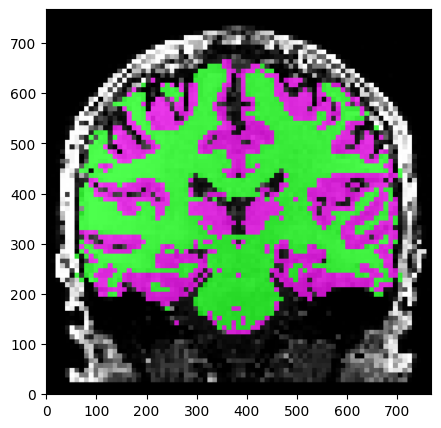

In [18]:
display_image('t1_mask_slice_47.png')

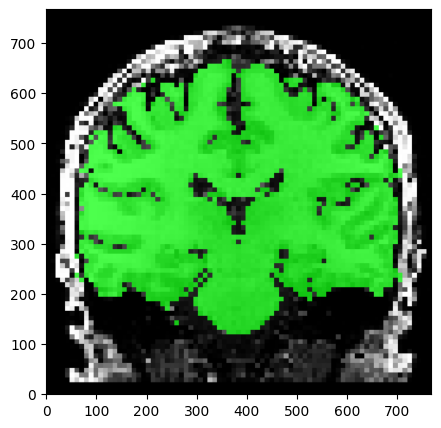

In [19]:
display_image('t1_brain_slice_47.png')

Now having diffusion and masks, we can start computing useful information ! We will first compute DTI-derived maps such as FA, DTI tensors, and more. Let's have a look at what `scil_dti_metrics.py` can offer:

In [20]:
!scil_dti_metrics.py --help

INFO:root:Scilpy version: 1.7.dev0
usage: scil_dti_metrics.py [-h] [-f] [--mask MASK] [--method method_name]
                           [--not_all] [--ad file] [--evecs file]
                           [--evals file] [--fa file] [--ga file] [--md file]
                           [--mode file] [--norm file] [--rgb file]
                           [--rd file] [--tensor file]
                           [--tensor_format {fsl,nifti,mrtrix,dipy}]
                           [--non-physical file] [--pulsation string]
                           [--residual file] [-v [{DEBUG,INFO,WARNING}]]
                           [--force_b0_threshold]
                           in_dwi in_bval in_bvec

Script to compute all of the Diffusion Tensor Imaging (DTI) metrics.

By default, will output all available metrics, using default names. Specific
names can be specified using the metrics flags that are listed in the "Metrics
files flags" section.

If --not_all is set, only the metrics specified explicitly by 

In [21]:
# Compute DTI metrics using our computed brain mask
!scil_dti_metrics.py {dwi} {bval} {bvec} --mask brainmask.nii.gz -f

INFO:root:Scilpy version: 1.7.dev0
/home/thea1603/workspace/tutorial_scilpy/.env/lib/python3.10/site-packages/dipy/reconst/dti.py:501: RuntimeWarning: invalid value encountered in divide
  return 3 * np.sqrt(6) * determinant((A_squiggle / A_s_norm))
/home/thea1603/workspace/tutorial_scilpy/.env/lib/python3.10/site-packages/dipy/reconst/dti.py:2122: RuntimeWarning: divide by zero encountered in log
  D[..., 6] = -np.log(b0)


Let's look at what the previous script has output:

In [22]:
!ls

ad.nii.gz
b0.nii.gz
b0_slice_47.png
brainmask.nii.gz
dti_residual_iqr_residuals.npy
dti_residual_mean_residuals.npy
dti_residual.nii.gz
dti_residual_q1_residuals.npy
dti_residual_q3_residuals.npy
dti_residual_residuals_stats.png
dti_residual_std_residuals.npy
fa.nii.gz
ga.nii.gz
gm.nii.gz
label_info.txt
md.nii.gz
mode.nii.gz
physically_implausible_signals_mask.nii.gz
pulsation_and_misalignment_std_b0.nii.gz
pulsation_and_misalignment_std_dwi.nii.gz
rd.nii.gz
rgb.nii.gz
scilpy_tutorial.ipynb
t1_brain_slice_47.png
t1_mask_slice_47.png
t1_slice_47.png
tensor_evals_e1.nii.gz
tensor_evals_e2.nii.gz
tensor_evals_e3.nii.gz
tensor_evals.nii.gz
tensor_evecs.nii.gz
tensor_evecs_v1.nii.gz
tensor_evecs_v2.nii.gz
tensor_evecs_v3.nii.gz
tensor.nii.gz
tensor_norm.nii.gz
wm.nii.gz


That's a lot of output ! Let's observe the FA to assert that our DTI reconstruction went well.

In [23]:
!scil_screenshot_volume.py fa.nii.gz fa.png --axis coronal --slice_id 47 -f

INFO:root:Scilpy version: 1.7.dev0


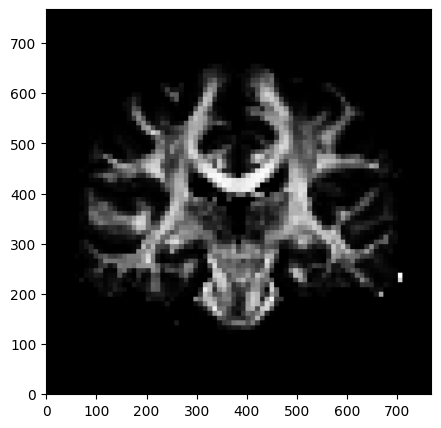

In [24]:
display_image('fa_slice_47.png')

We can now compute the fiber orientation distribution function (fODF) image. First, we'll need to compute the fiber response function (FRF). For speed and due to the limited data we have, we'll compute the FRF as single-shell single-tissue.

In [25]:
!scil_frf_ssst.py {dwi} {bval} {bvec} ssst_frf.txt --mask_wm wm.nii.gz -f -v

INFO:root:Scilpy version: 1.7.dev0
INFO:root:Number of indices is 3793 with threshold of 0.70
INFO:root:Found 3793 voxels with FA threshold 0.70 for FRF estimation
INFO:root:FRF eigenvalues: [0.0013485  0.00031291 0.00031291]
INFO:root:Ratio for smallest to largest eigen value is 0.232
INFO:root:Mean of the b=0 signal for voxels used for FRF: 437.2477722167969


Then, let's compute fODFs again for single-shell single-tissue data. We'll use the brain mask as we don't need to compute fODFs in the ventricles or in the cranium.

In [26]:
!scil_fodf_ssst.py {dwi} {bval} {bvec} ssst_frf.txt fodf.nii.gz --mask brainmask.nii.gz --processes 4 -v -f

INFO:root:Scilpy version: 1.7.dev0


In [27]:
!scil_visualize_fodf.py fodf.nii.gz --output fodf.png --silent -f --slice_index 47 --axis coronal

INFO:root:Scilpy version: 1.7.dev0


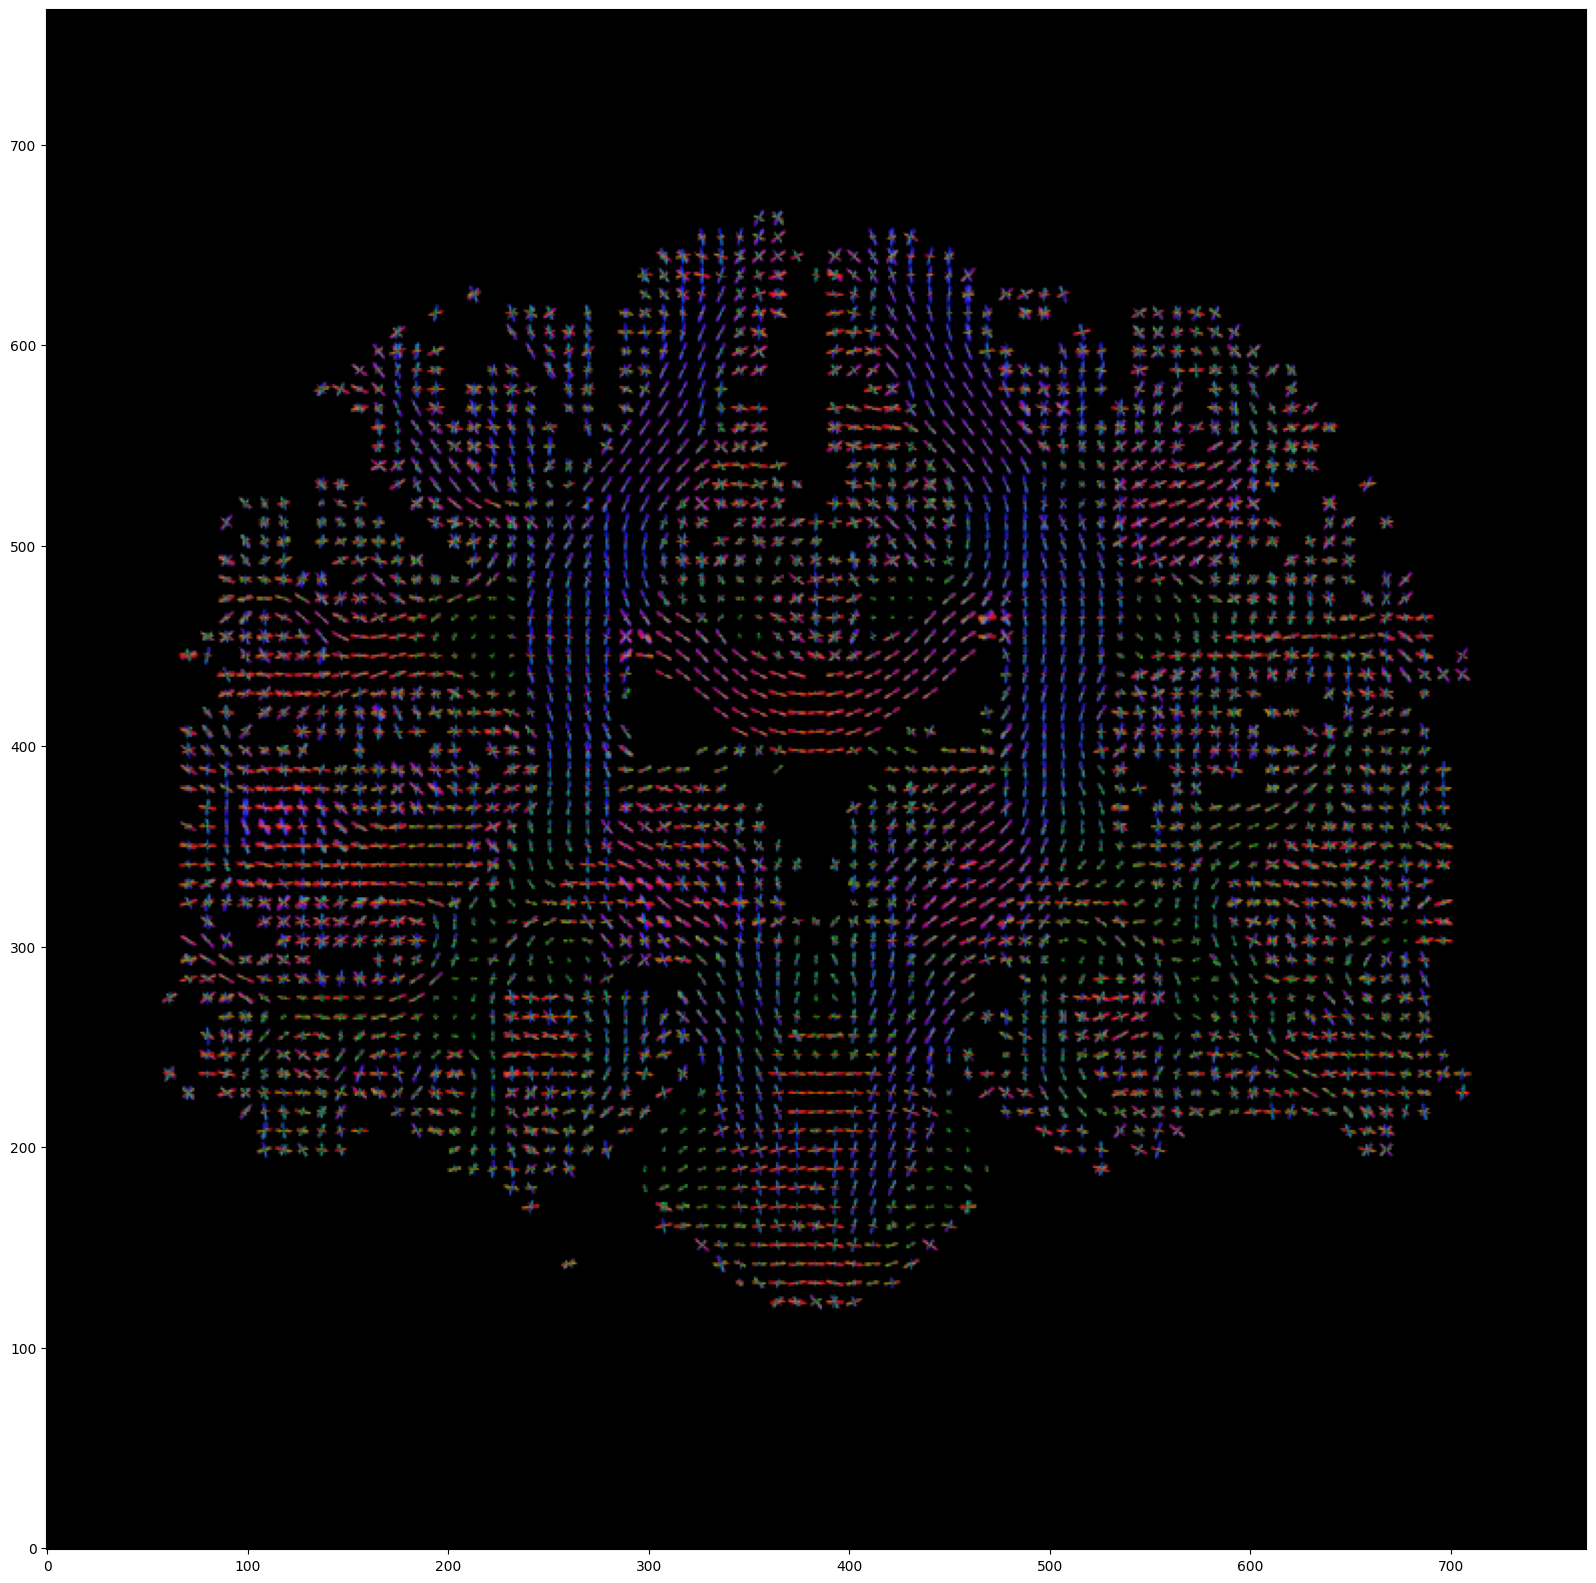

In [28]:
display_image('fodf.png', big=True)

Looks great ! We'll compute some fODF maps then get on to tracking.

In [29]:
!scil_fodf_metrics.py fodf.nii.gz -f

INFO:root:Scilpy version: 1.7.dev0


In [30]:
!rm nufo_slice_47.png
!scil_screenshot_volume.py nufo.nii.gz nufo.png --axis coronal --slice_id 47 -f --volume_cmap_name jet

rm: cannot remove 'nufo_slice_47.png': No such file or directory
INFO:root:Scilpy version: 1.7.dev0


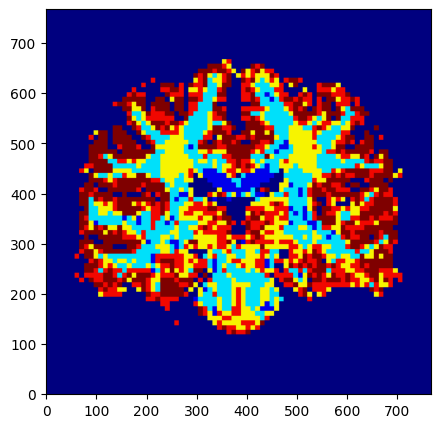

In [31]:
display_image('nufo_slice_47.png')

Looks great ! We have around 1 fiber population in the corpus callosum, 2-3 in the deep white matter and none in the ventricles and outside the brain. Now let's track !

# Tracking

In this section, we will perform tractography using the volumes previously computed by running **scil_tracking_local.py**.

References:

- [1]: Garyfallidis, E. (2013). Towards an accurate brain tractography (Doctoral dissertation, University of Cambridge).
- [2]: Descoteaux, M., Deriche, R., Knosche, T. R., & Anwander, A. (2008). Deterministic and probabilistic tractography based on complex fibre orientation distributions. IEEE transactions on medical imaging, 28(2), 269-286.
- [3]: Girard, G., Whittingstall, K., Deriche, R., & Descoteaux, M. (2014). Towards quantitative connectivity analysis: reducing tractography biases. Neuroimage, 98, 266-278.
- [4]: Aydogan, D. B., & Shi, Y. (2020). Parallel transport tractography. IEEE transactions on medical imaging, 40(2), 635-647.
- [5]: Daducci, A., Dal Palù, A., Lemkaddem, A., & Thiran, J. P. (2014). COMMIT: convex optimization modeling for microstructure informed tractography. IEEE transactions on medical imaging, 34(1), 246-257.
- [6]: Garyfallidis, E., Côté, M. A., Rheault, F., & Descoteaux, M. (2016). QuickBundlesX: sequential clustering of millions of streamlines in multiple levels of detail at record execution time. 24th International Society of Magnetic Resonance in Medicine (ISMRM).
- [7]: St-Onge, E., Schilling, K. G., & Rheault, F. (2023, October). BundleSeg: A versatile, reliable and reproducible approach to white matter bundle segmentation. In International Workshop on Computational Diffusion MRI (pp. 47-57). Cham: Springer Nature Switzerland.

scilpy offers several tracking algorithms: EuDX (peaks tracking) [1], deterministic and probabilistic tracking [2], Particle-Filtering Tractography (PFT) [3] and Parallel Transport Tractography [4]. For ease and speed, we will just perform simple probabilistic tracking using default parameters. If you don't have a GPU, remove the `--use_gpu` argument from the second command.

In [32]:
!scil_tracking_local.py fodf.nii.gz wm.nii.gz wm.nii.gz subject.trk -f -v --sh_to_pmf --nt 1000000 --use_gpu


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
INFO:root:Scilpy version: 1.7.dev0
INFO:root:Saved tractogram to subject.trk.                                      
INFO:root:Total runtime of 63.20s.


Now that we have our tractogram, let's see what we can do with it:

In [33]:
!scil_search_keywords.py tractogram

INFO:root:Scilpy version: 1.7.dev0
INFO:root:===================== scil_bundle_compute_endpoints_map.py =====================
INFO:root:Computes the endpoint map of a bundle.
INFO:root:================= End of scil_bundle_compute_endpoints_map.py ==================
INFO:root:

INFO:root:=========================== scil_bundle_diameter.py ============================
INFO:root:Script to estimate the diameter of bundle(s) along their length.
INFO:root:======================== End of scil_bundle_diameter.py ========================
INFO:root:

INFO:root:====================== scil_bundle_filter_by_occurence.py ======================
INFO:root:Use multiple versions of a same bundle and detect the most probable voxels by
using a threshold on the occurence, voxel-wise.
INFO:root:================== End of scil_bundle_filter_by_occurence.py ===================
INFO:root:

INFO:root:=========================== scil_bundle_label_map.py ===========================
INFO:root:Compute the label imag

Some interesting examples include **scil_tractogram_commit.py** to run COMMIT [4], **scil_tractogram_cut_streamlines.py** to filter and cut streamlines according to a region of interest, **scil_tractogram_filter_by_anatomy.py** to filter a tractogram according to a bunch of anatomical rules (cortial parcellation, CSF masks, looping, length, etc.), **scil_tractogram_qbx.py** to run QuickBundlesX [5], **scil_tractogram_segment_bundles.py** to run BundleSeg [6] and **scil_tractogram_apply_transform.py** to register a tractogram to a new space using a transformation matrix from ANTs.

Let's have a look at the reconstructed tractogram. Again for ease and speed, we will only display 1/20 of the streamlines.

In [34]:
try:
    import google.colab
except:
    !scil_visualize_bundles.py subject.trk --local_coloring --shape line --subsample 20

INFO:root:Scilpy version: 1.7.dev0


# Connectivity

In this section, we'll use the previously computed tractogram, as well as the parcellation downloaded at the beginning of the notebook to compute various connectivity matrices. We'll use **scil_labels_remove.py** to remove unwanted labels from our parcellation, **scil_tractogram_segment_bundles_for_connectivity.py** to segment the tractogram into bundles going from region to region, **scil_connectivity_compute_matrices.py** to compute the connectivity matrices, **scil_connectivity_math.py** to perform operations on the matrices and **scil_visualize_connectivity.py** to display the connectivity matrices.

Now that we have a tractogram, let's compute connectivity ! At the beginning of the notebook, we downloaded a list of regions in the parcellation we also downloaded. Let's have a look at it.

In [35]:
!scil_screenshot_volume.py {t1} --in_labelmap {aparc} --slice_ids 47 --axis coronal t1_labels.png -f

INFO:root:Scilpy version: 1.7.dev0


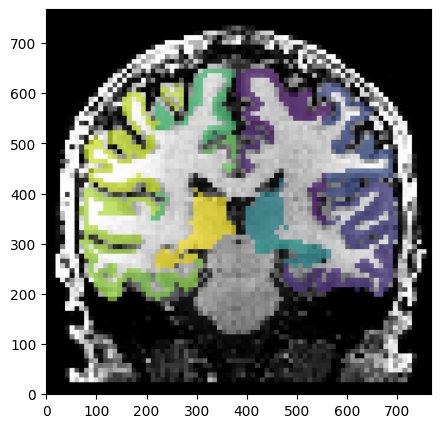

In [36]:
display_image('t1_labels_slice_47.png')

We previously downloaded a list of labels associated with our parcellation. Let's see what the regions are:

In [37]:
!column -s, -t < label_info.txt

new label   freesurfef label   freesurfer name
1           2                  "Left-Cerebral-White-Matter"
1           41                 "Right-Cerebral-White-Matter"
1           77                 "WM-hypointensities"
1           85                 "Optic-Chiasm"
1           1004               "ctx-lh-corpuscallosum"
1           2004               "ctx-rh-corpuscallosum"
2           251                "CC_Posterior"
2           252                "CC_Mid_Posterior"
2           253                "CC_Central"
2           254                "CC_Mid_Anterior"
2           255                "CC_Anterior"
3           1032               "ctx-lh-frontalpole"
4           1014               "ctx-lh-medialorbitofrontal"
5           1012               "ctx-lh-lateralorbitofrontal"
6           1019               "ctx-lh-parsorbitalis"
7           1020               "ctx-lh-parstriangularis"
8           1018               "ctx-lh-parsopercularis"
9           1027               "ctx-lh-rostralmidd

From the list above, we can see that the regions include the WM (labels 1 and 2). Let's remove them from the parcellation:

In [38]:
!scil_labels_remove.py {aparc} aparc_nowm.nii.gz -i 1 2 -f -v

INFO:root:Scilpy version: 1.7.dev0


Perfect ! We are now ready to compute the structual connectivity from our tractogram. First, we'll need to segment our tractogram using our parcellation, to obtain bundles going from one region to another. 

In [39]:
!scil_tractogram_segment_bundles_for_connectivity.py subject.trk aparc_nowm.nii.gz subject.hdf5 -f --save_raw --out_dir subject_connectivity --out_labels_list label_list.txt -f

INFO:root:Scilpy version: 1.7.dev0


Next, we'll compute the connectivity matrices. We actually have many choices for our connectivity. Do we want to know how many streamlines go between each region ? The volume occupied by those streamlines ? The average FA along them ? Luckily for us, **`scil_connectivity_compute_matrices.py`** can do it all, and more !

In [40]:
!scil_connectivity_compute_matrices.py subject.hdf5 aparc_nowm.nii.gz --volume subject_volume.npy --streamline_count subject_count.npy --length subject_length.npy --metrics fa.nii.gz subject_fa.npy -f

INFO:root:Scilpy version: 1.7.dev0


Now that we have our connectivity matrices, let's display them. The next cell is used to transform our label list into a json file scilpy can use. This is usually not necessary if the labels come from a freesurfer parcellation as scilpy already offers a lookup table for these.

In [41]:
 !jq -R 'split(",") | { (.[0]) : .[2] }' label_info.txt | jq -s add > lut.json
!sed -i 's/\\"//g' lut.json

jq: error (at label_info.txt:99): Cannot use null (null) as object key


Now that we have our label names, let's visualize our connectivity matrices !

In [42]:
!scil_visualize_connectivity.py subject_fa.npy subject_fa.png -f --display_legend --lookup lut.json --labels_list label_list.txt --name_axis --axis_text_size 3 3 --chord subject_fa_chord.png
!scil_visualize_connectivity.py subject_count.npy subject_count.png -f --display_legend --lookup lut.json --labels_list label_list.txt --name_axis --axis_text_size 2 3 --axis_text_angle 45 0 --log
!scil_visualize_connectivity.py subject_volume.npy subject_volume.png -f --display_legend --lookup lut.json --labels_list label_list.txt --name_axis --axis_text_size 3 3

INFO:root:Scilpy version: 1.7.dev0
INFO:root:Scilpy version: 1.7.dev0
INFO:root:Scilpy version: 1.7.dev0


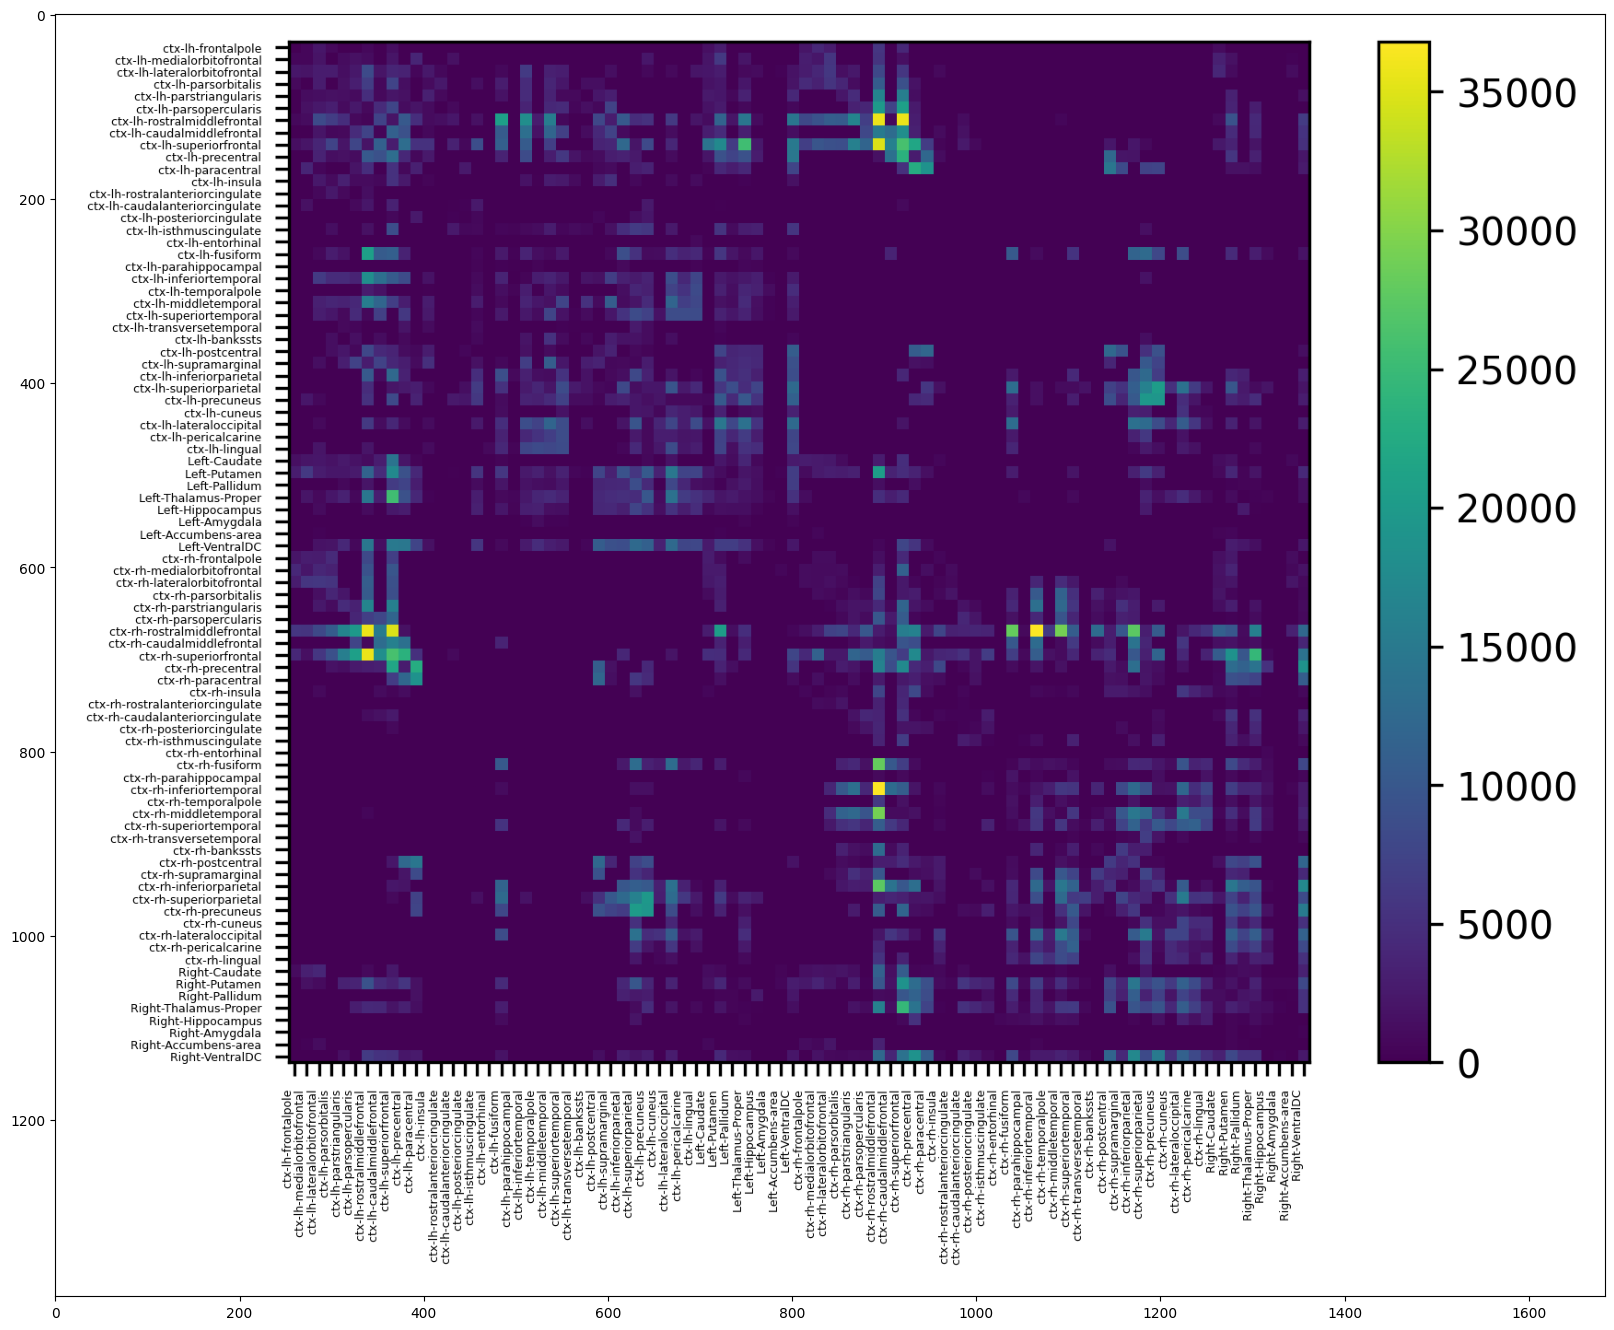

In [43]:
display_image('subject_volume.png', invert=False,big=True)

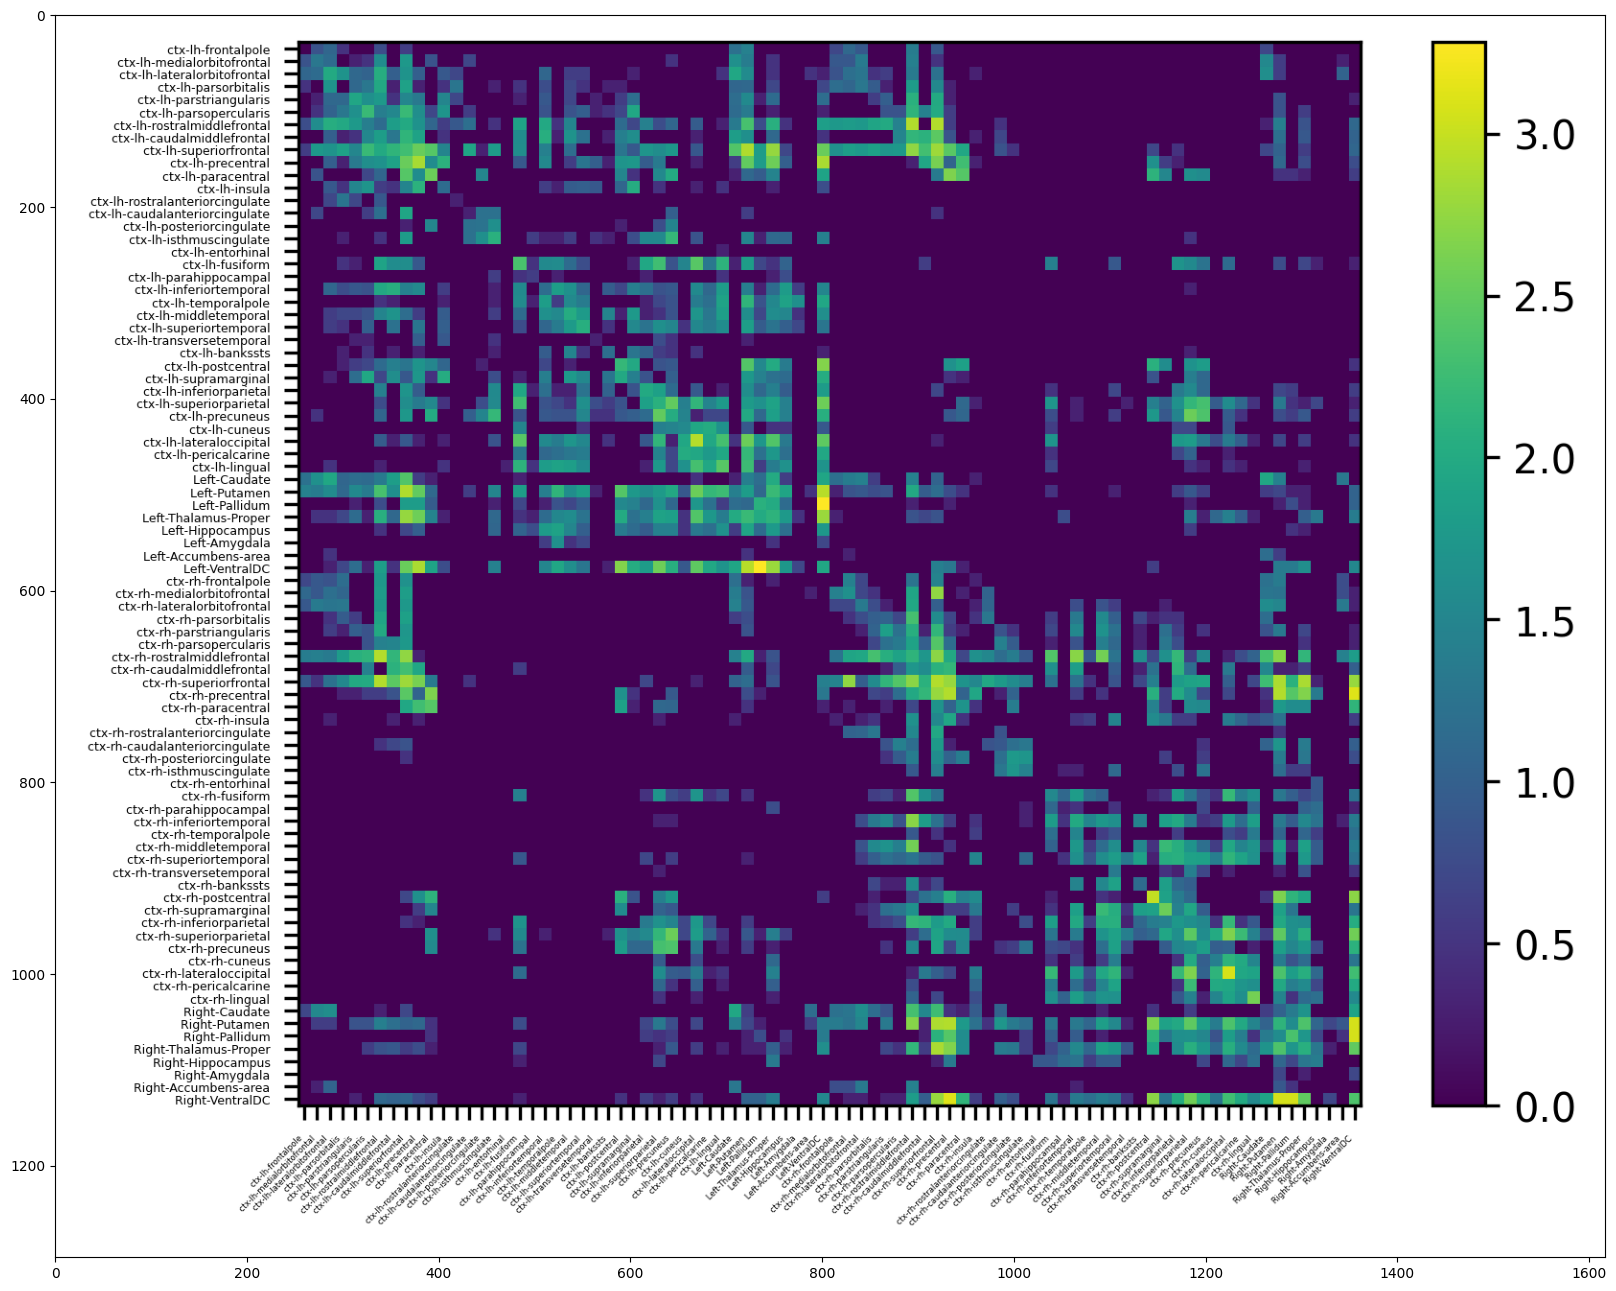

In [44]:
display_image('subject_count.png', invert=False,big=True)

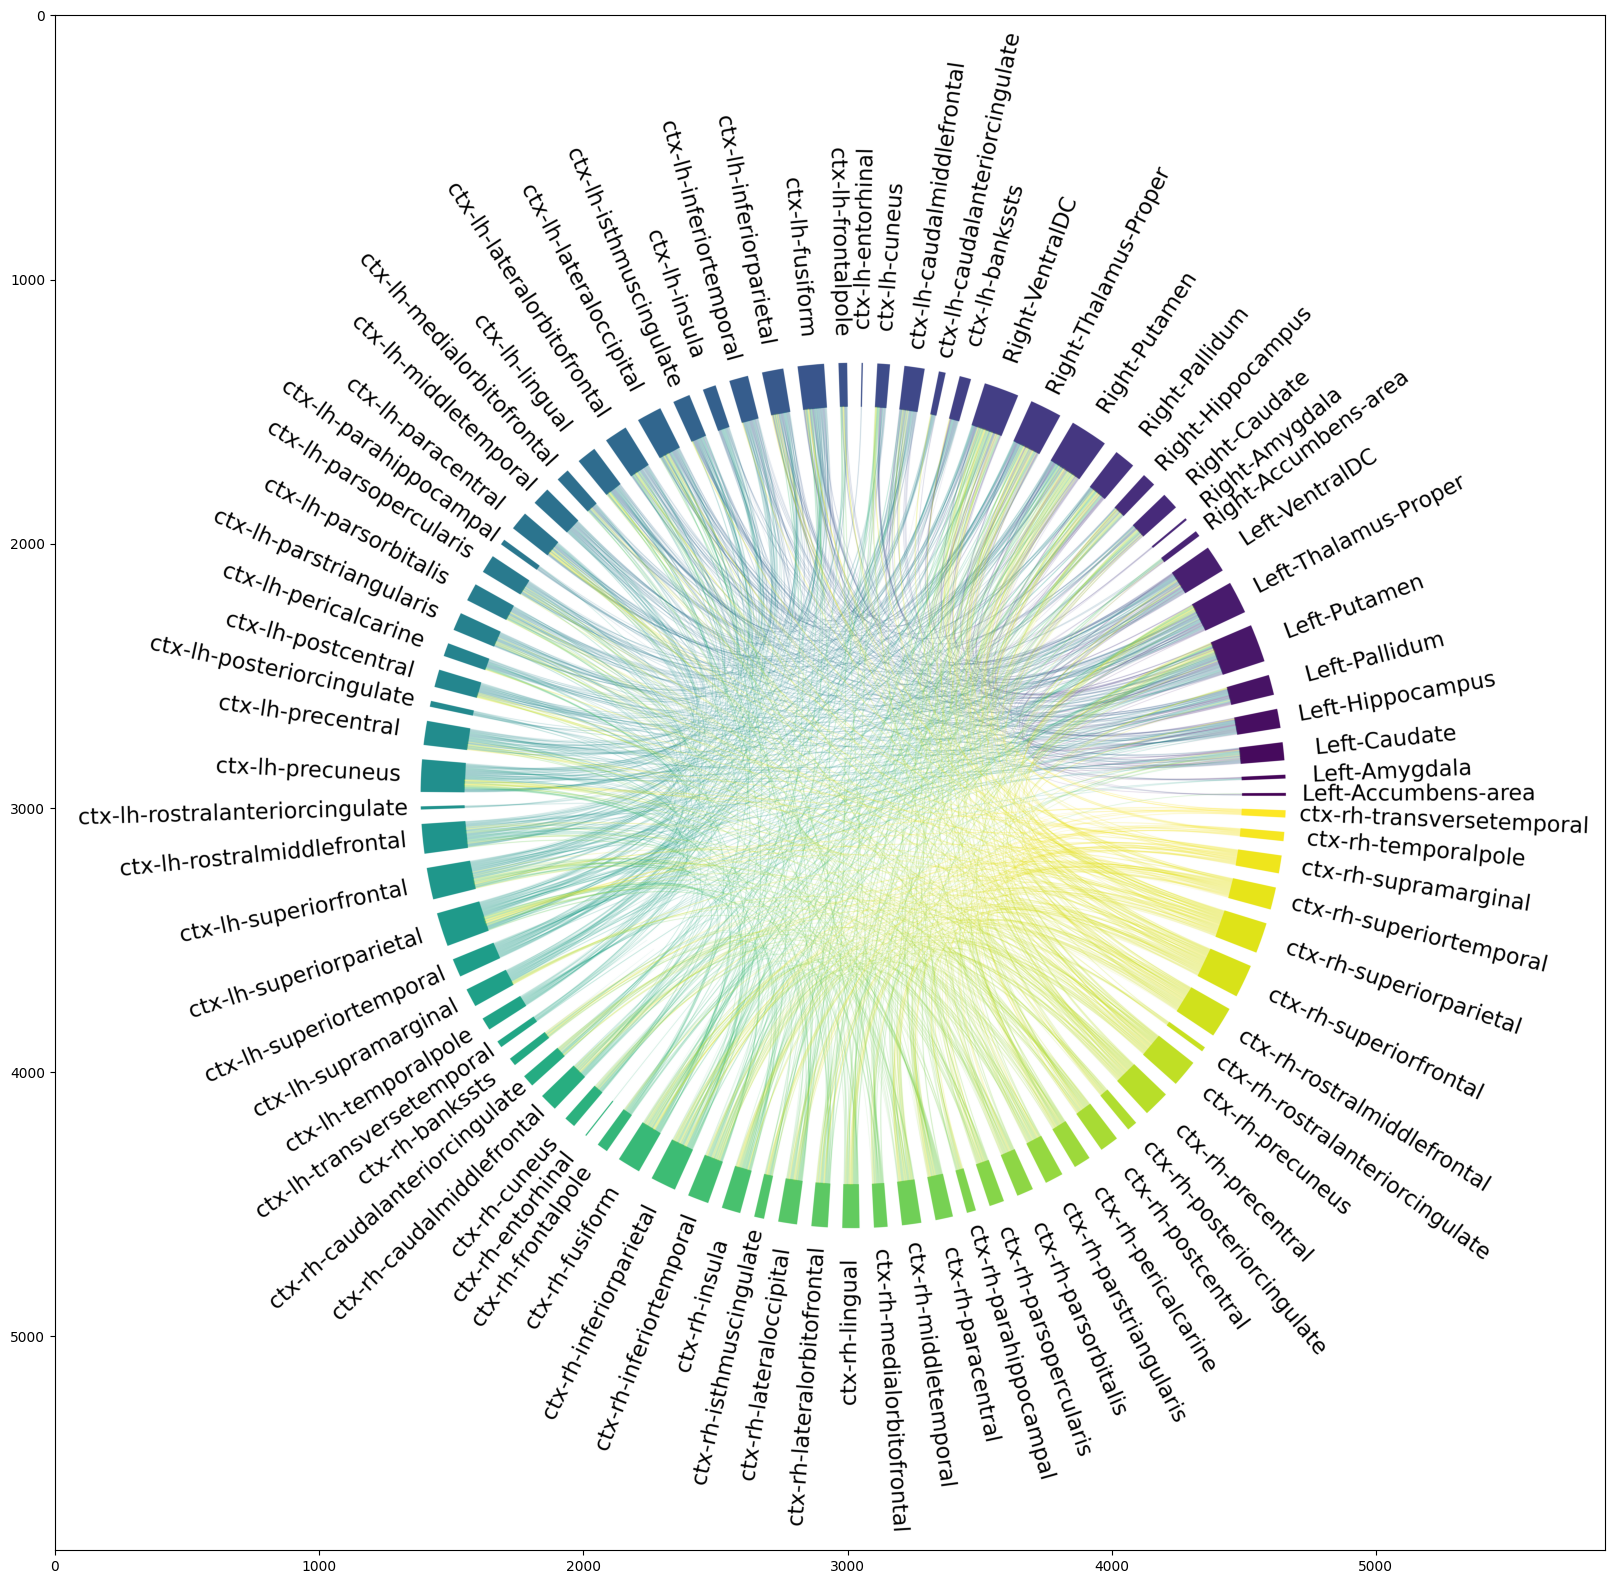

In [45]:
display_image('subject_fa_chord.png', invert=False,big=True)

Now that we have our connectivity matrices, we can do operations on them ! Let's see what scilpy has to offer:

In [46]:
!scil_search_keywords.py connectivity matrices

INFO:root:Scilpy version: 1.7.dev0
INFO:root:============================= scil_compute_pca.py ==============================
INFO:root:Script to compute PCA analysis on diffusion metrics.
INFO:root:========================== End of scil_compute_pca.py ==========================
INFO:root:

INFO:root:=================== scil_connectivity_compare_populations.py ===================
INFO:root:Performs a network-based statistical comparison for populations g1 and g2.
INFO:root:=============== End of scil_connectivity_compare_populations.py ================
INFO:root:

INFO:root:==================== scil_connectivity_compute_matrices.py =====================
INFO:root:This script computes a variety of measures in the form of connectivity
matrices.
INFO:root:================= End of scil_connectivity_compute_matrices.py =================
INFO:root:

INFO:root:========================= scil_connectivity_filter.py ==========================
INFO:root:Script to facilitate filtering of connectiv

We can do a lot ! For example, using **scil_connectivity_graph_measures.py** we can compute graph measures like centrality, clusters, Rich club coefficient. Using **scil_connectivity_compare_populations.py** we can compute p-values for each edge of two populations of connectivity matrices.

Since we only have one subject, let's focus on something simple: binarizing our matrix. For example, let's disregard connections with fewer than 50 streamlines. To do so, we'll use **`scil_connectivity_math.py`**. Let's see what it has to offer first:

In [47]:
!scil_connectivity_math.py --help

INFO:root:Scilpy version: 1.7.dev0
usage: scil_connectivity_math.py [-h] [--data_type DATA_TYPE]
                                 [--exclude_background]
                                 [-v [{DEBUG,INFO,WARNING}]] [-f]
                                 {lower_threshold,upper_threshold,lower_threshold_eq,upper_threshold_eq,lower_threshold_otsu,upper_threshold_otsu,lower_clip,upper_clip,absolute_value,round,ceil,floor,normalize_sum,normalize_max,log_10,log_e,convert,invert,addition,subtraction,multiplication,division,mean,std,correlation,union,intersection,difference}
                                 in_matrices [in_matrices ...] out_matrix

Performs an operation on a list of matrices. The supported operations are
listed below.

Some operations such as multiplication or addition accept float value as
parameters instead of matrices.
> scil_connectivity_math.py multiplication mat.npy 10 mult_10.npy

    lower_threshold: MAT THRESHOLD
        All values below the threshold will be set to zer

Some useful operations are **thresholds**, **normalize**, **mean/stdev**, **correlation**, and more ! Let's use **lower_threshold** to binarize our matrix.

In [48]:
!scil_connectivity_math.py lower_threshold subject_count.npy 50 subject_count_binary.npy -f
!scil_visualize_connectivity.py subject_count_binary.npy subject_count_binary.png -f --display_legend --lookup lut.json --labels_list label_list.txt --name_axis --axis_text_size 3 3

INFO:root:Scilpy version: 1.7.dev0
INFO:root:Scilpy version: 1.7.dev0


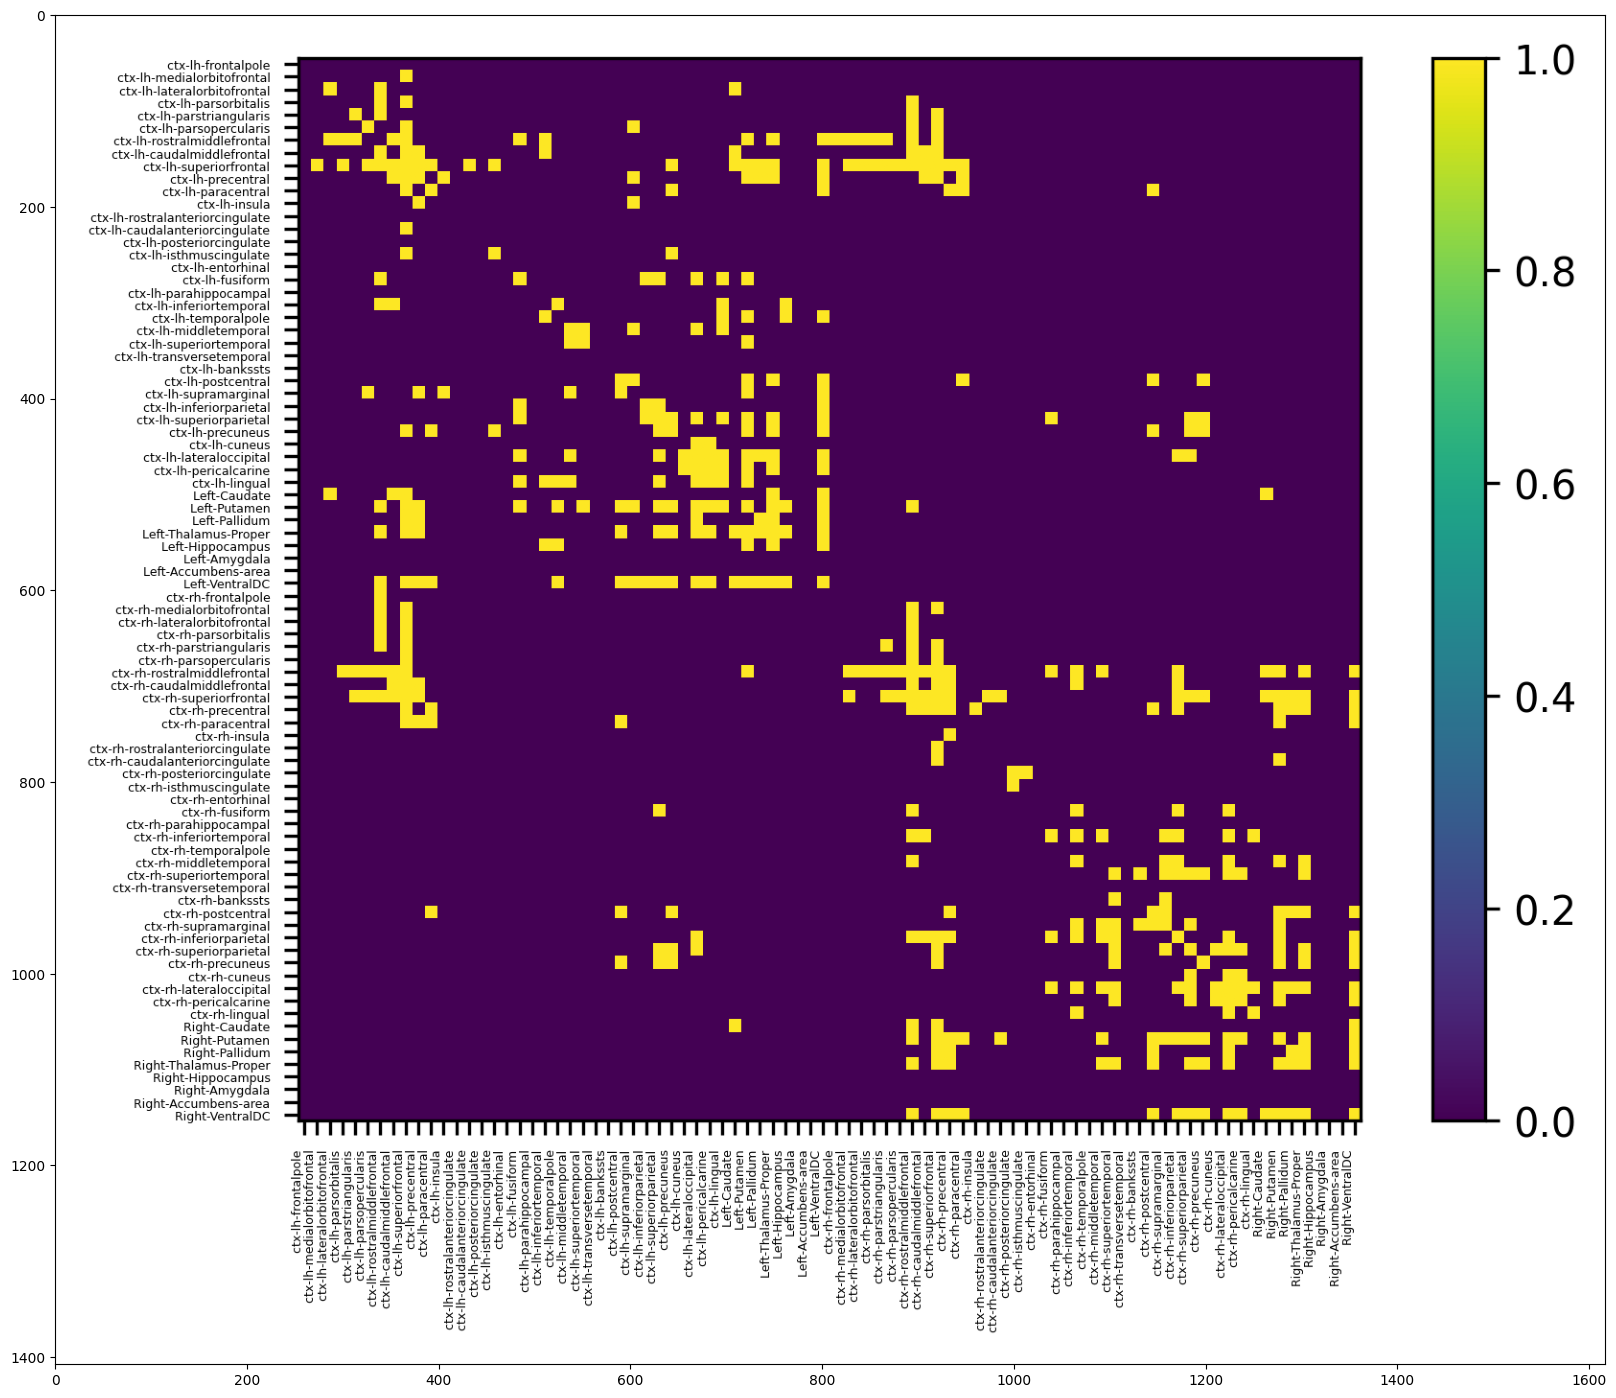

In [49]:
display_image('subject_count_binary.png', invert=False,big=True)

We can also perform operations on a group of matrices, like compute the mean. Ideally, this would be performed on a population, but let's do the mean of streamline count and volume to obtain a sort of "connection strength" metric. First, we'll normalize our matrices so they are in the same range.

In [50]:
!scil_connectivity_math.py normalize_sum subject_count.npy subject_count_norm.npy -f
!scil_connectivity_math.py normalize_sum subject_volume.npy subject_volume_norm.npy -f

INFO:root:Scilpy version: 1.7.dev0
INFO:root:Scilpy version: 1.7.dev0


In [51]:
!scil_connectivity_math.py mean subject_volume_norm.npy subject_count_norm.npy subject_strength.npy -f
!scil_visualize_connectivity.py subject_strength.npy subject_strength.png -f --display_legend --lookup lut.json --labels_list label_list.txt --name_axis --axis_text_size 3 3

INFO:root:Scilpy version: 1.7.dev0
INFO:root:Scilpy version: 1.7.dev0


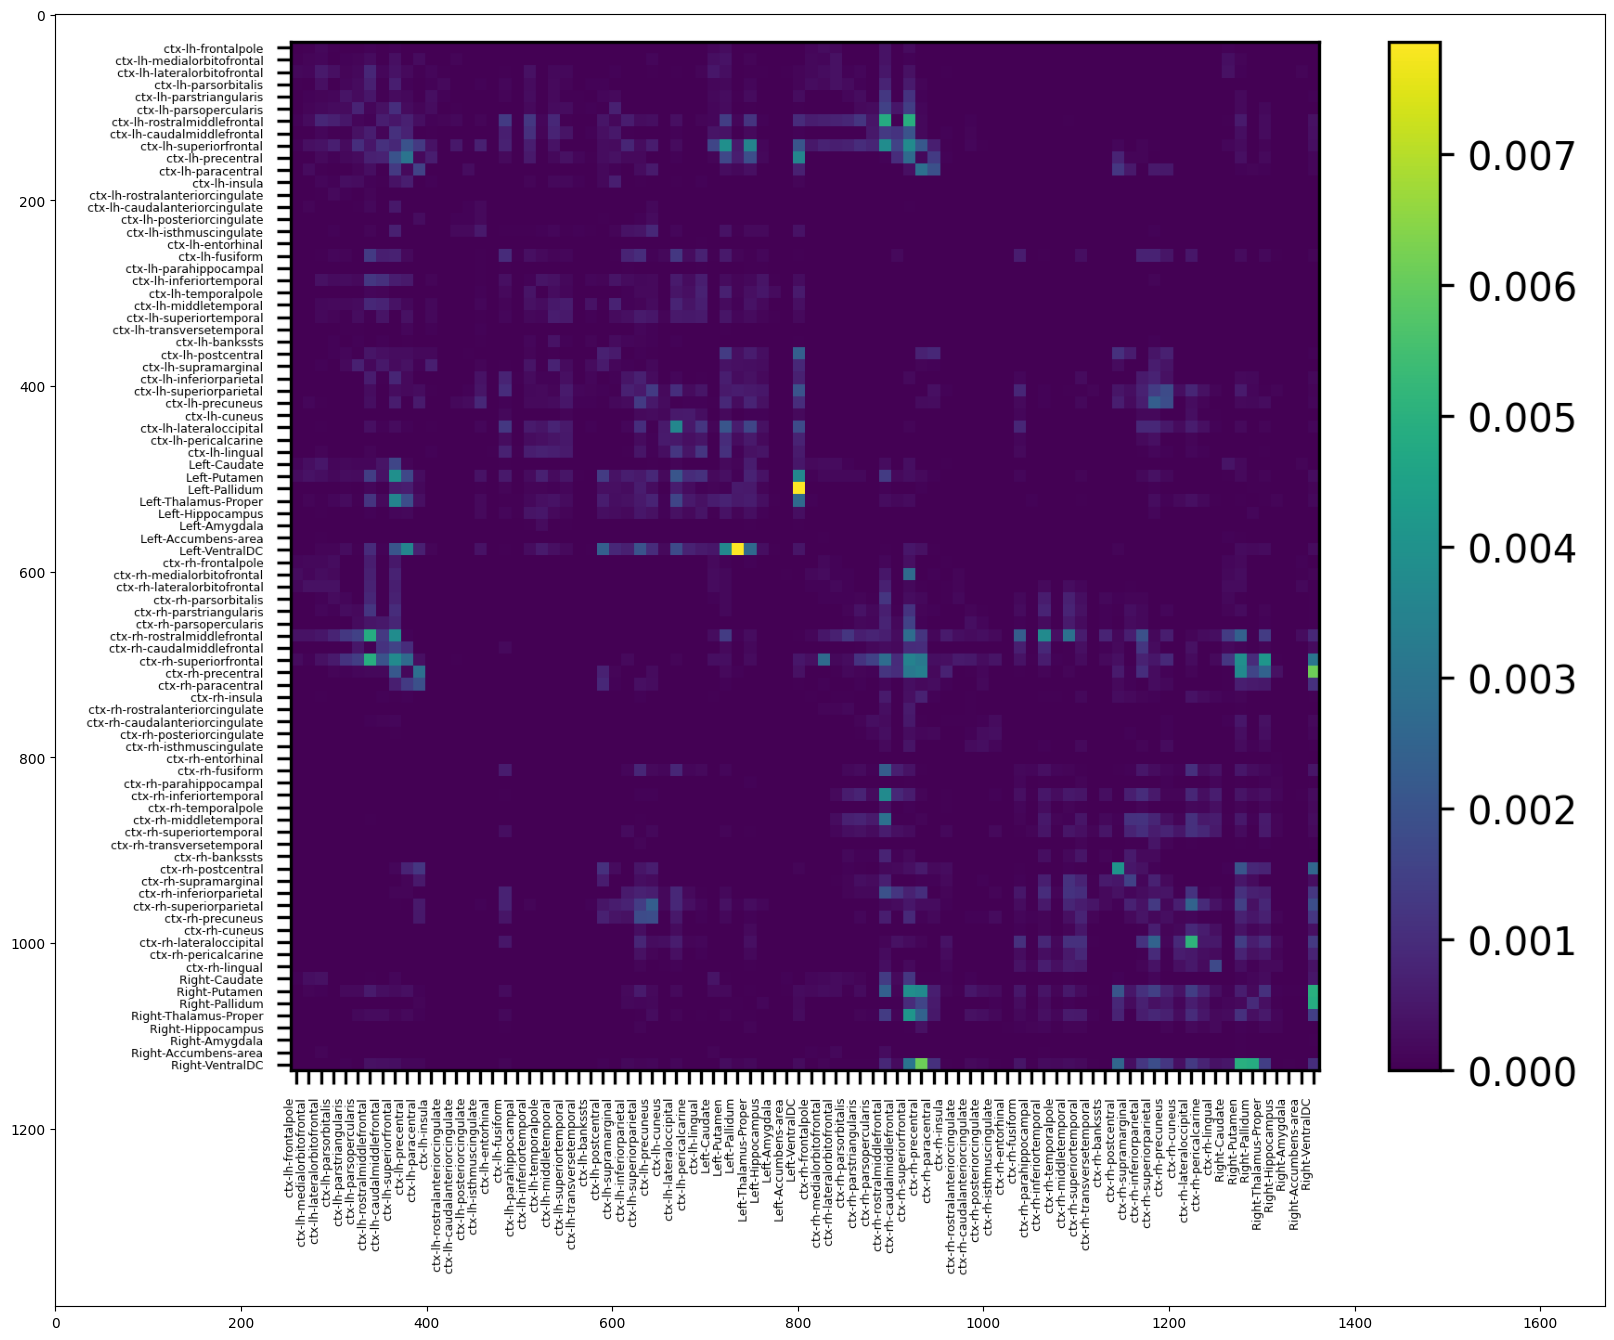

In [52]:
display_image('subject_strength.png', invert=False,big=True)

Let's look at some connection, for example between the middle temporal lobe (67) and the frontal middle rostral gyrus (52): 

In [53]:
!scil_screenshot_bundle.py subject_connectivity/final_connections/52_67.trk {t1} --roi wm.nii.gz --output_suffix 52_67 -f --right

INFO:root:Scilpy version: 1.7.dev0


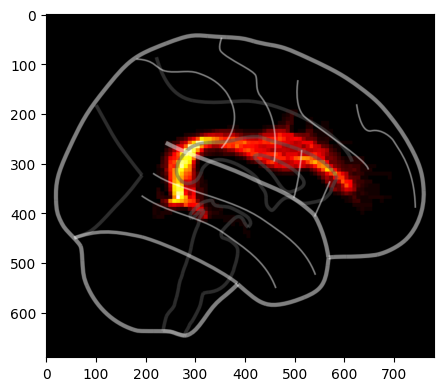

In [54]:
display_image('sagittal_52_67_glass.png', False)

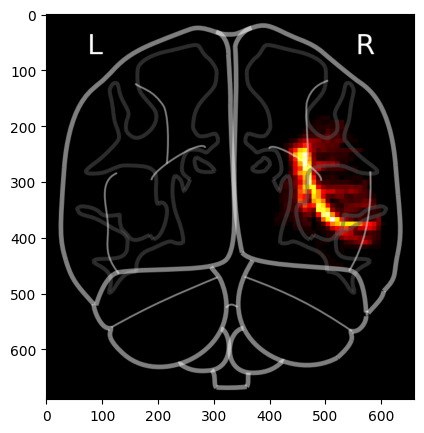

In [55]:
display_image('coronal_52_67_glass.png', False)

Cool, we found the arcuate fasciculus ! The connection between the right ventral diencephalon (88) and precentral gyrus (54) seems to be particularly strong. Let's check it out:

In [56]:
!scil_screenshot_bundle.py subject_connectivity/final_connections/54_88.trk {t1} --roi wm.nii.gz --output_suffix 54_88 -f --right

INFO:root:Scilpy version: 1.7.dev0


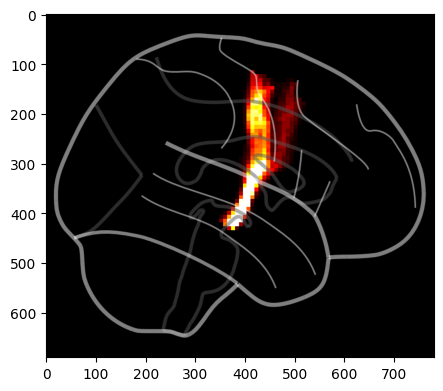

In [57]:
display_image('sagittal_54_88_glass.png', False)

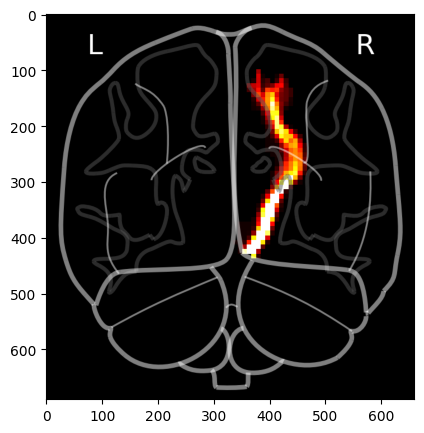

In [58]:
display_image('coronal_54_88_glass.png', False)

# Recap

In this tutorial, we have seen how we can use scilpy to go from raw diffusion to modelled diffusion (**scil_dti_metrics.py**, **scil_frf_ssst.py**, **scil_fodf_ssst.py**) to tractography (**scil_tracking_local.py**) and finally to connectivity (**scil_tractogram_segment_bundles_for_connectivity.py**, **scil_connectivity_compute_matrices.py**, **scil_visualize_connectivity.py**), and how we can QC every step in the process to make sure that everything went well.